In [45]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_colwidth', None)
import random
import scikitplot as skplt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from transformers import DefaultDataCollator

from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification

In [22]:
X_train = pd.read_csv('../datasets/future_statements_dataset/X_train.csv')["statement"]
y_train = pd.read_csv('../datasets/future_statements_dataset/y_train.csv')["future"]

In [100]:
params = {'MAX_LENGTH': 128,
          'EPOCHS': 50,
          #learningrate
          'LEARNING_RATE': 5e-5,
          'FT_EPOCHS': 10,
          'OPTIMIZER': 'adam',
          'FL_GAMMA': 2.0,
          'FL_ALPHA': 0.2,
          'BATCH_SIZE': 64,
          'NUM_STEPS': len(X_train.index) // 64,
          #dropouts:
          'DISTILBERT_DROPOUT': 0.2,
          'DISTILBERT_ATT_DROPOUT': 0.2,
          'LAYER_DROPOUT': 0.2,
          'KERNEL_INITIALIZER': 'GlorotNormal',
          'BIAS_INITIALIZER': 'zeros',
          'POS_PROBA_THRESHOLD': 0.90,
          'ADDED_LAYERS': 'Dense 256, Dense 32, Dropout 0.2',
          'LR_SCHEDULE': '5e-5 for 6 epochs, Fine-tune w/ adam for 2 epochs @2e-5',
          'FREEZING': 'All DistilBERT layers frozen for 6 epochs, then unfrozen for 2',
          'CALLBACKS': '[early_stopping w/ patience=0]',
          'RANDOM_STATE': 42
          }

In [24]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use i

In [25]:
def tokenize_func(examples):
    return tokenizer(examples["statement"], padding="max_length", truncation=True)

In [26]:
def batch_encode(_tokenizer, texts, batch_size=256, max_length=params['MAX_LENGTH']):
    """""""""
    A function that encodes a batch of texts and returns the texts'
    corresponding encodings and attention masks that are ready to be fed
    into a pre-trained transformer model.
    Input:
        - _tokenizer:   Tokenizer object from the PreTrainedTokenizer Class
        - texts:       List of strings where each string represents a text
        - batch_size:  Integer controlling number of texts in a batch
        - max_length:  Integer controlling max number of words to tokenize in a given text
    Output:
        - input_ids:       sequence of texts encoded as a tf.Tensor object
        - attention_mask:  the texts' attention mask encoded as a tf.Tensor object
    """""""""

    input_ids = []
    attention_mask = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = _tokenizer.batch_encode_plus(batch,
                                              max_length=max_length,
                                              padding='max_length',
                                              truncation=True,
                                              return_attention_mask=True,
                                              return_token_type_ids=False
                                              )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])

    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [27]:
train = pd.concat([X_train, y_train], axis=1)

In [28]:
# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

# Create train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [29]:
# Sort index
X_train.sort_index(inplace=True)
X_valid.sort_index(inplace=True)
X_test.sort_index(inplace=True)
y_train.sort_index(inplace=True)
y_valid.sort_index(inplace=True)
y_test.sort_index(inplace=True)

# Reset index
X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_valid.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

print('Training data:   ', len(X_train.index), ' rows. Negatives:', (y_train==0).sum(), 'Positives:', (y_train==1).sum())
print('Validation data: ', len(X_valid.index), ' rows. Negatives:', (y_valid==0).sum(), 'Positives:', (y_valid==1).sum())
print('Test data:       ', len(X_test.index), ' rows. Negatives:', (y_test==0).sum(), 'Positives:', (y_test==1).sum())

Training data:    1600  rows. Negatives: 808 Positives: 792
Validation data:  400  rows. Negatives: 185 Positives: 215
Test data:        500  rows. Negatives: 257 Positives: 243


In [30]:
# Encode X_train
X_train_ids, X_train_attention = batch_encode(tokenizer, X_train.tolist())

# Encode X_valid
X_valid_ids, X_valid_attention = batch_encode(tokenizer, X_valid.tolist())

# Encode X_test
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test.tolist())

In [31]:
X_train_short = X_train[[1, 2, 501, 502]]
y_train_short = y_train[[1, 2, 501, 502]]

In [32]:
tokenizer(X_train_short.to_list(), padding=True, truncation=True)

{'input_ids': [[101, 2116, 2477, 2031, 2042, 2187, 2369, 1998, 2116, 2477, 26751, 2149, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1996, 5137, 4832, 3201, 2000, 6509, 1999, 14972, 3036, 2473, 5813, 16666, 2575, 1006, 2432, 1007, 2006, 5712, 1010, 2029, 2001, 15645, 4233, 2076, 2256, 8798, 1997, 1996, 2473, 2197, 2238, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2023, 4535, 2036, 7534, 1996, 4119, 1997, 26616, 1037, 4187, 4106, 1997, 1996, 2248, 2576, 3496, 1999, 1996, 2422, 1997, 1996, 8041, 2824, 1997, 1996, 2627, 2260, 2706, 1998, 2013, 1996, 6466, 1997, 1996, 16360, 2121, 7874, 27466, 2008, 2168, 4023, 2097, 2031, 2006, 2023, 5041, 1998, 20868, 2890, 24759, 10732, 3085, 7057, 2005, 1996, 25546, 3989, 1997, 1996, 6327, 5248, 1997, 2163, 2029, 2003, 1996, 21

In [33]:
y_train_short.to_list()

[0, 0, 1, 1]

In [34]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  mode='min',
                                                  min_delta=0,
                                                  patience=0,
                                                  restore_best_weights=True)

In [40]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

if not os.path.exists('./checkpoints/'):
    print('Train model...')
    model.fit(x=[X_train_ids, X_train_attention]
              , y=y_train.to_numpy()
              , epochs=3
              #, batch_size=params['BATCH_SIZE']
              #, steps_per_epoch=params['NUM_STEPS']
              , validation_data=([X_valid_ids, X_valid_attention], y_valid.to_numpy())
              #, callbacks=[early_stopping]
              , verbose=1
             )
    model.save_weights('./checkpoints/my_checkpoint')
else:
    print('Already trained weights available...')

Already trained weights available...


In [43]:
loss, acc = model.evaluate(x=[X_test_ids, X_test_attention]
                           #, y=y_test
                           , verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

16/16 [==============================] - 117s 7s/step - loss: 0.0325 - sparse_categorical_accuracy: 0.9960
Restored model, accuracy: 99.60%


In [101]:
if not y_pred:
    y_pred = model.predict([X_test_ids, X_test_attention]
                           , verbose=1)
prediction_logits = y_pred[0]
prediction_probs = tf.nn.softmax(prediction_logits,axis=1).numpy()
y_pred_thresh = np.where(prediction_probs > params['POS_PROBA_THRESHOLD'], 1, 0)

In [102]:
y_pred_t = pd.Series([el[1] for el in y_pred_thresh])

# Get evaluation results
accuracy = accuracy_score(y_test, y_pred_t)
auc_roc = roc_auc_score(y_test, y_pred_t)

print(accuracy)
print(auc_roc)

0.996
0.995996861539447


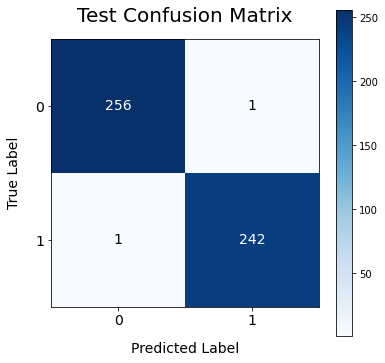

In [103]:
skplt.metrics.plot_confusion_matrix(y_pred_t.tolist()
                                    , y_test.to_list()
                                    , figsize=(6, 6)
                                    , text_fontsize=14)
plt.title(label='Test Confusion Matrix', fontsize=20, pad=17)
plt.xlabel('Predicted Label', labelpad=14)
plt.ylabel('True Label', labelpad=14)

plt.savefig('../figures/future_statements_confusionmatrix.png', dpi=300.0, transparent=False)

In [ ]:
#model.save('saved_model/my_model2', save_format='h5')

In [ ]:
#data_collator = DefaultDataCollator(return_tensors="tf")